In [6]:
# pip install datasets umap-learn pycddlib dask dask-expr cvxopt
from datasets import load_dataset
from collections import defaultdict
import os
import pandas as pd
import random
import numpy as np
import pyarrow as pa
import pyarrow.ipc as ipc
import dask.dataframe as dd

from numba import jit

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy.spatial import ConvexHull

import polytope as pc

from pypoman import compute_polytope_vertices
from pypoman import plot_polygon, project_polytope
from pypoman import compute_polytope_halfspaces

import cdd

from umap import UMAP

import manifold

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
dataset = load_dataset("calabi-yau-data/polytopes-4d", cache_dir="C:/Users/esultano/git/polytopes/data/huggingface", split="full").shuffle(seed=42)
print("Verfügbare Aufteilungen:", dataset)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/237 [00:00<?, ?it/s]

Verfügbare Aufteilungen: Dataset({
    features: ['vertices', 'vertex_count', 'facet_count', 'point_count', 'dual_point_count', 'h11', 'h12', 'euler_characteristic'],
    num_rows: 473800776
})


In [3]:
percentage = 0.01
chunk_size = 10000
max_dfs = 3
sample_size = int(percentage * len(dataset))

In [4]:
dfs = []
for i in range(0, min(sample_size, max_dfs * chunk_size), chunk_size):
    chunk = dataset.select(range(i, min(i + chunk_size, sample_size)))
    dfs.append(chunk.to_pandas())

df = pd.concat(dfs, ignore_index=True)

In [ ]:
# Dictionary to store vertex count occurrences
vertex_count_counts = defaultdict(int)

# Numba-optimized function to count unique values
@jit(nopython=True)
def count_vertex_counts(arr, unique_vals, counts):
    for val in arr:
        for i, unique_val in enumerate(unique_vals):
            if val == unique_val:
                counts[i] += 1
                break
    return counts

# Process dataset in chunks
for i in range(0, len(dataset), chunk_size):
    # Select a chunk and convert it to a DataFrame
    chunk = dataset.select(range(i, min(i + chunk_size, len(dataset))))
    chunk_df = chunk.to_pandas()
    
    # Get vertex_count column as numpy array
    vertex_array = chunk_df['vertex_count'].values
    
    # Get unique values and initialize counts
    unique_vals = np.unique(vertex_array)
    counts = np.zeros(len(unique_vals), dtype=np.int64)
    
    # Use the Numba-accelerated function for counting
    counts = count_vertex_counts(vertex_array, unique_vals, counts)
    
    # Aggregate counts in the main dictionary
    for val, count in zip(unique_vals, counts):
        vertex_count_counts[val] += count

# Convert the results to a DataFrame for easier viewing
vertex_count_summary = pd.DataFrame(list(vertex_count_counts.items()), columns=['vertex_count', 'count'])
print(vertex_count_summary.sort_values(by='count', ascending=False))

In [ ]:
# Anzahl der Proben je Vertex-Anzahl
unique_vertex_counts = dataset['vertex_count'].unique()
target_samples_per_vertex = sample_size // len(unique_vertex_counts)

# Randomisierte Chunk-Indices für Auswahl einer kleineren Teilmenge der Daten
chunk_indices = random.sample(range(0, len(dataset), chunk_size), max_dfs)

# Initialisieren von Dictionaries zum Sammeln balancierter Samples
balanced_samples = defaultdict(list)

# Durchlaufen zufällig ausgewählter Chunks
for i in chunk_indices:
    chunk = dataset.select(range(i, min(i + chunk_size, len(dataset))))
    chunk_df = chunk.to_pandas()

    # Gruppieren nach Vertex Count und Sampling
    for vertex_count, group in chunk_df.groupby('vertex_count'):
        if len(balanced_samples[vertex_count]) < target_samples_per_vertex:
            sample_needed = target_samples_per_vertex - len(balanced_samples[vertex_count])
            balanced_samples[vertex_count].append(group.sample(n=min(sample_needed, len(group))))

# Kombinieren aller gesammelten Samples in einen DataFrame
dfs = [pd.concat(samples) for samples in balanced_samples.values() if samples]
df = pd.concat(dfs, ignore_index=True)

print(f"Balanced dataset created with shape: {df.shape}")

In [4]:
df['vertex_to_point_ratio'] = df['vertex_count'] / df['point_count']
stats = df['vertex_to_point_ratio'].describe()
print(stats)

count    30000.000000
mean         0.414814
std          0.160594
min          0.035573
25%          0.294118
50%          0.404762
75%          0.523810
max          0.956522
Name: vertex_to_point_ratio, dtype: float64


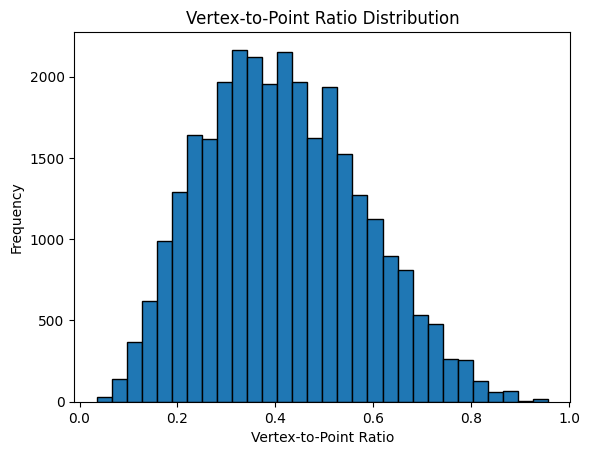

In [5]:
plt.hist(df['vertex_to_point_ratio'], bins=30, edgecolor='black')
plt.title("Vertex-to-Point Ratio Distribution")
plt.xlabel("Vertex-to-Point Ratio")
plt.ylabel("Frequency")
plt.show()

In [6]:
data = df[['vertex_count', 'point_count', 'vertex_to_point_ratio', 'h11', 'h12']]
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

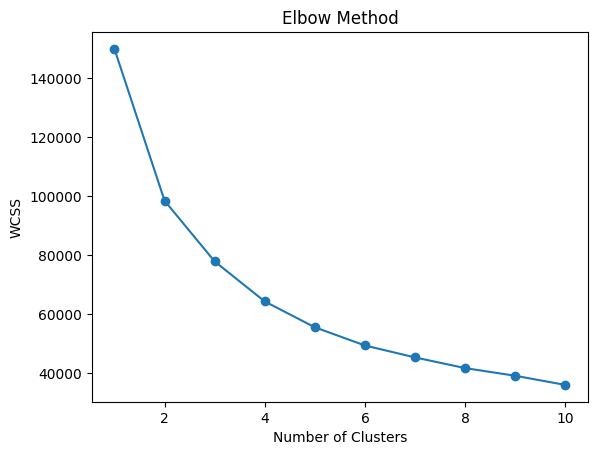

In [7]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normalized)
    wcss.append(kmeans.inertia_)

# Plot WCSS to find the elbow point
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

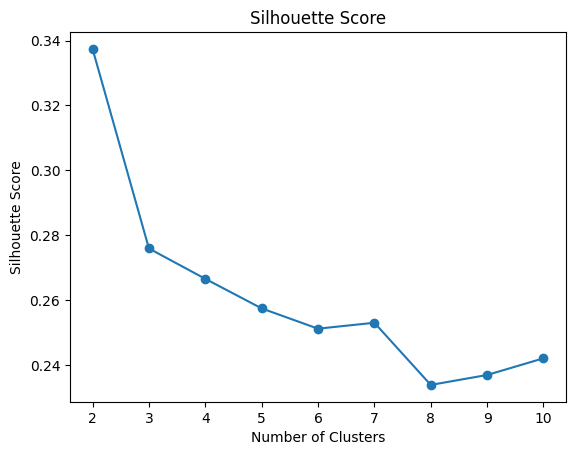

In [8]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normalized)
    score = silhouette_score(data_normalized, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(data_normalized)

In [10]:
fig = px.scatter_3d(df, 
                    x='vertex_to_point_ratio', 
                    y='h11', 
                    z='h12', 
                    color='cluster',
                    title="3D Scatter Plot of Clusters in Polytopes",
                    labels={
                        'vertex_to_point_ratio': 'Vertex-to-Point Ratio',
                        'h11': 'Hodge Number h11',
                        'h12': 'Hodge Number h12'
                    })

fig.update_traces(marker=dict(size=1))

fig.write_html("3d_scatter_plot.html")

In [11]:
df['symmetry_ratio'] = df['vertex_count'] / df['dual_point_count']

In [12]:
symmetry_stats = df['symmetry_ratio'].describe()
print(symmetry_stats)

count    30000.000000
mean         0.428721
std          0.202676
min          0.030534
25%          0.280702
50%          0.395349
75%          0.540822
max          1.571429
Name: symmetry_ratio, dtype: float64


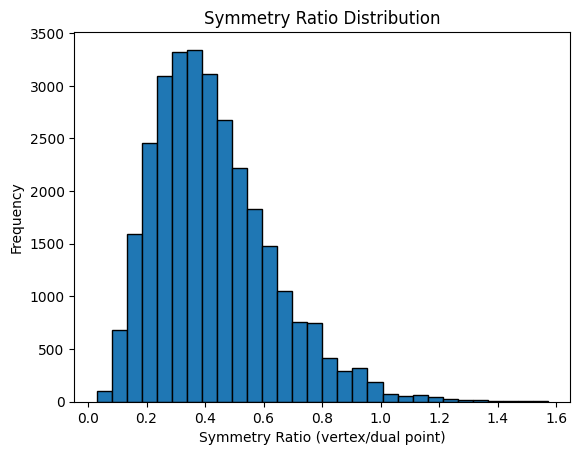

In [13]:
plt.hist(df['symmetry_ratio'], bins=30, edgecolor='black')
plt.title("Symmetry Ratio Distribution")
plt.xlabel("Symmetry Ratio (vertex/dual point)")
plt.ylabel("Frequency")
plt.show()

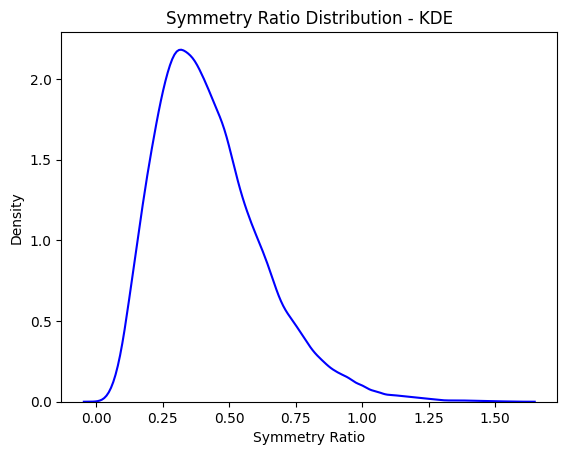

In [14]:
# Plot the KDE for 'symmetry_ratio'
sns.kdeplot(df['symmetry_ratio'], color='blue')

# Add labels and title
plt.title("Symmetry Ratio Distribution - KDE")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Density")
plt.show()

C:\Users\esultano\AppData\Local\Temp\ipykernel_13052\105459467.py:7: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



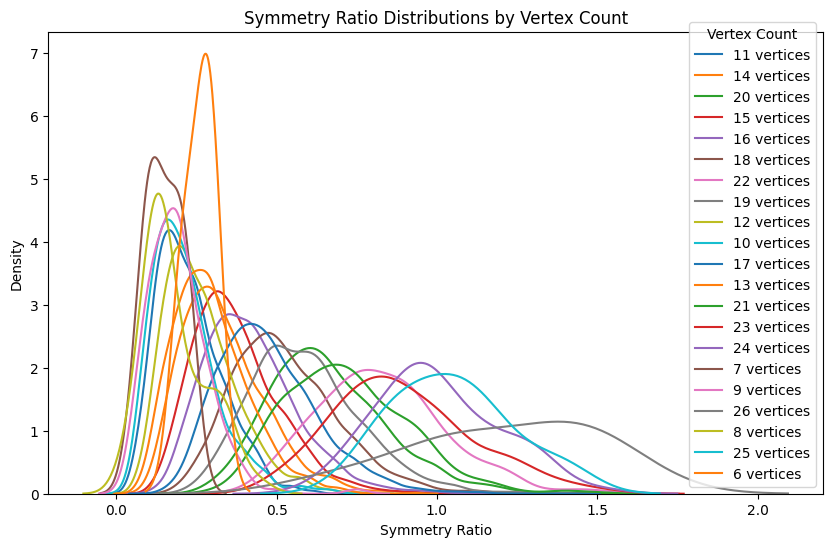

In [15]:
unique_vertex_counts = df['vertex_count'].unique()

plt.figure(figsize=(10, 6))

for count in unique_vertex_counts:
    subset = df[df['vertex_count'] == count]
    sns.kdeplot(subset['symmetry_ratio'], label=f'{count} vertices', linewidth=1.5)

plt.title("Symmetry Ratio Distributions by Vertex Count")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Density")
plt.legend(title="Vertex Count")
plt.show()

In [16]:
def calculate_hull_volume(vertices):
    vertices = np.vstack(vertices)
    hull = ConvexHull(vertices)
    return hull.volume

df['volume'] = df['vertices'].apply(calculate_hull_volume)

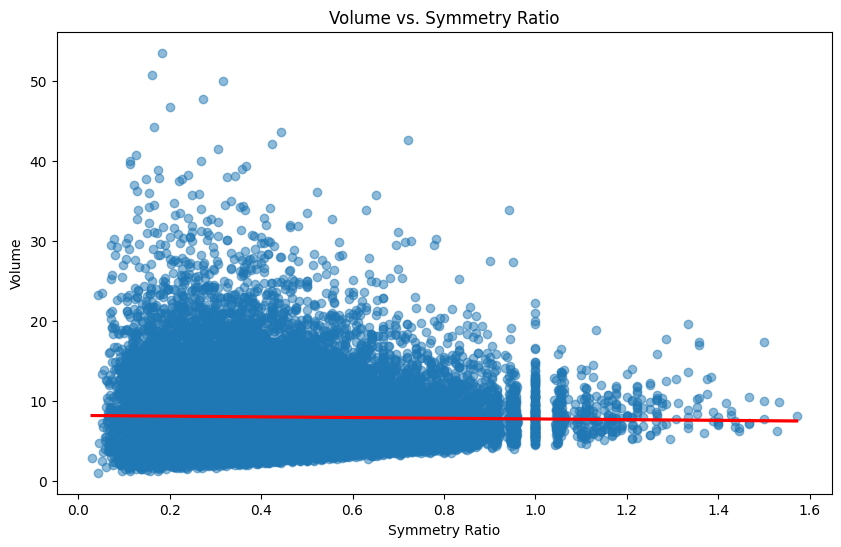

In [17]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='symmetry_ratio', y='volume', scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title("Volume vs. Symmetry Ratio")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Volume")
plt.show()

C:\Users\esultano\AppData\Local\Temp\ipykernel_13052\1198195103.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



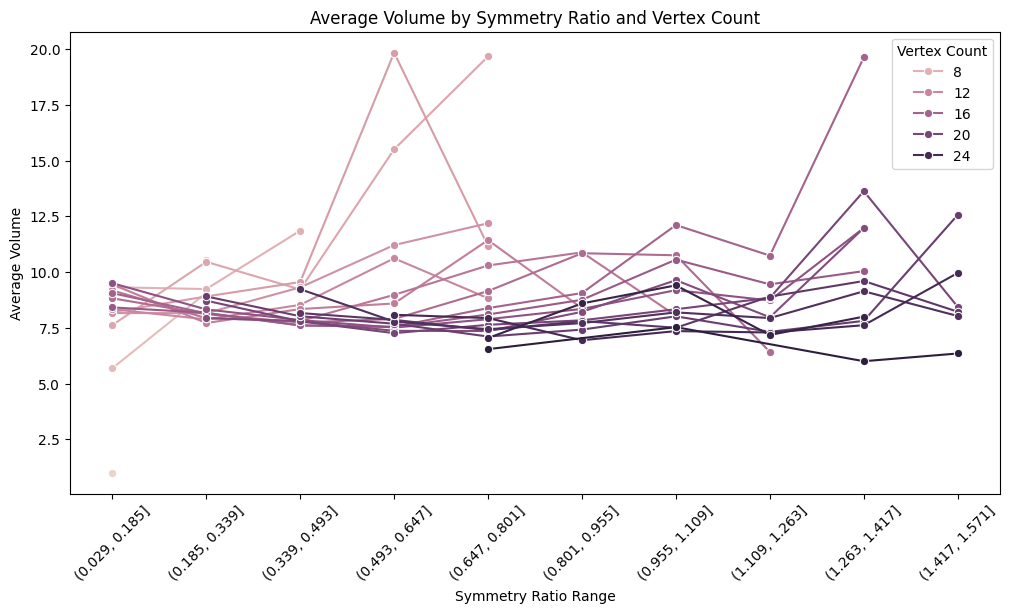

In [30]:
# Group by vertex count and symmetry ratio range
df['symmetry_range'] = pd.cut(df['symmetry_ratio'], bins=10)
grouped = df.groupby(['vertex_count', 'symmetry_range'])['volume'].mean().reset_index()
grouped['symmetry_range'] = grouped['symmetry_range'].astype(str)

# Plot the lineplot with updated symmetry_range format
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='symmetry_range', y='volume', hue='vertex_count', marker="o")
plt.xticks(rotation=45)
plt.title("Average Volume by Symmetry Ratio and Vertex Count")
plt.xlabel("Symmetry Ratio Range")
plt.ylabel("Average Volume")
plt.legend(title="Vertex Count")
plt.show()

In [ ]:
correlation = df['volume'].corr(df['symmetry_ratio'])
print(f"Correlation between Volume and Symmetry Ratio: {correlation:.2f}")

Correlation between Volume and Symmetry Ratio: -0.02


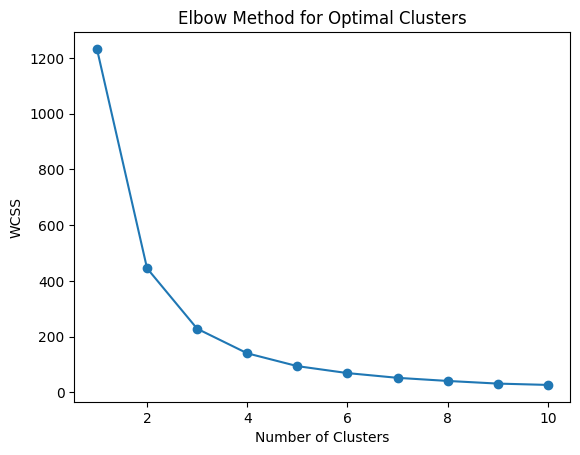

In [ ]:
symmetry_data = df[['symmetry_ratio']].values

# Plot WCSS to find the elbow point
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(symmetry_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['symmetry_cluster'] = kmeans.fit_predict(symmetry_data)

In [ ]:
percentile = 0.99
threshold = df['symmetry_ratio'].quantile(percentile)
df['is_outlier'] = df['symmetry_ratio'] > threshold

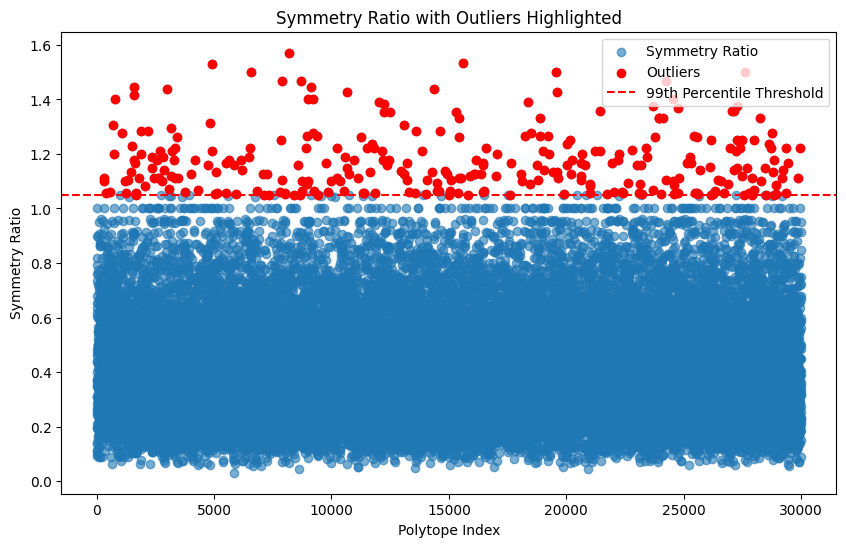

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['symmetry_ratio'], label="Symmetry Ratio", alpha=0.6)
plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']]['symmetry_ratio'], color='red', label="Outliers")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"{int(percentile * 100)}th Percentile Threshold")
plt.title("Symmetry Ratio with Outliers Highlighted")
plt.xlabel("Polytope Index")
plt.ylabel("Symmetry Ratio")
plt.legend()
plt.show()

c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



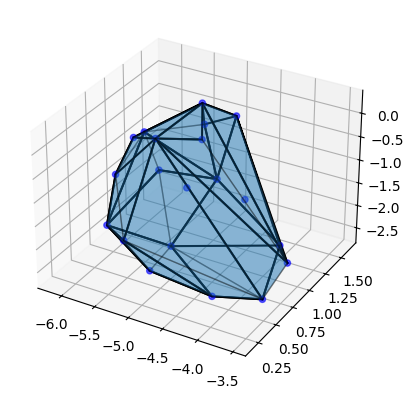

In [ ]:
outliers = df[df['is_outlier']].head(5)

first_outlier = outliers.iloc[0]

vertices_4d = first_outlier['vertices']
vertices_4d = np.vstack(vertices_4d)

#pca = PCA(n_components=3)
#vertices_3d = pca.fit_transform(vertices_4d)
umap = UMAP(n_components=3, random_state=42)
vertices_3d = umap.fit_transform(vertices_4d)

hull = ConvexHull(vertices_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], color='blue', alpha=0.6)

for simplex in hull.simplices:
    points = vertices_3d[simplex]
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-')

faces = Poly3DCollection(vertices_3d[hull.simplices], alpha=0.3, edgecolor='k')
ax.add_collection3d(faces)

plt.show()

In [ ]:
# see also https://github.com/mwalczyk/polychora?tab=readme-ov-file
# https://arxiv.org/abs/2403.11141
# https://pycddlib.readthedocs.io/en/latest/examples.html#polyhedron-adjacencies-and-incidences

#vertices_4d = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0,-2,1,2],[0,2,-1,-2],[0,0,0,-1],[0,0,-1,0],[0,-1,0,0],[1,-1,1,2],[1,-1,1,0],[0,-2,1,1],[0,-1,1,2],[0,-1,1,0],[0,0,1,1],[-1,0,-1,-1],[-1,1,0,0],[-1,2,-2,-2],[-1,-1,0,0],[-1,2,-1,-1]]

num_verts = vertices_4d.shape[0]
vertices = np.hstack((np.ones((num_verts,1)), vertices_4d))
mat = cdd.matrix_from_array(vertices, rep_type=cdd.RepType.GENERATOR)
poly = cdd.polyhedron_from_matrix(mat)

# get the adjacent vertices of each vertex
adjacencies = [list(x) for x in cdd.matrix_adjacency(mat)]
print(adjacencies)


[[9, 10, 5, 7], [9, 19, 5, 14], [5, 10, 13, 14, 16], [9, 19, 12, 7], [7, 9, 11, 12, 18], [0, 1, 2, 6, 10, 17, 19], [10, 13, 5, 15], [0, 3, 4, 8, 9, 15, 17], [10, 11, 15, 7], [0, 1, 3, 4, 7, 10, 12, 14], [0, 2, 5, 6, 8, 9, 11, 13], [4, 8, 10, 13, 18], [3, 4, 9, 14, 16], [2, 6, 10, 11, 18], [1, 2, 9, 12, 16], [6, 7, 8, 17, 18], [2, 12, 14, 18, 19], [19, 15, 5, 7], [4, 11, 13, 15, 16], [1, 3, 5, 16, 17]]


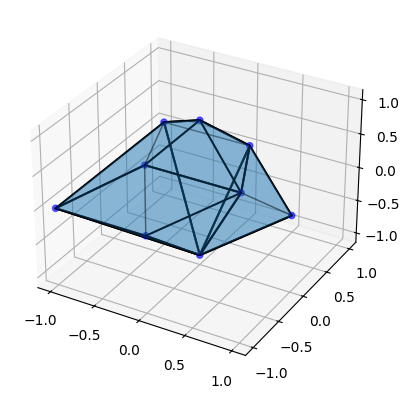

In [ ]:
# Project onto 3D by setting the fourth dimension to a fixed value (e.g., w = 0)
vertices_3d = vertices_4d[vertices_4d[:, 3] == 0][:, :3]  # Slicing at w=0

hull = ConvexHull(vertices_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], color='blue', alpha=0.6)

for simplex in hull.simplices:
    points = vertices_3d[simplex]
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-')

faces = Poly3DCollection(vertices_3d[hull.simplices], alpha=0.3, edgecolor='k')
ax.add_collection3d(faces)

plt.show()

In [ ]:
V = np.array(vertices_3d)
print(V)
poly_qhull = pc.qhull(V)
print(pc.volume(poly_qhull))

[[ 1  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [ 0  0 -1]
 [ 0 -1  0]
 [ 1 -1  1]
 [ 0 -1  1]
 [-1  1  0]
 [-1 -1  0]]
1.4533333333333334


Predict the Hodge numbers based on vertex count.

In [ ]:
# Extract features (vertex count) and targets (h11, h12)
X = df[['vertex_count']]
y = df[['h11', 'h12']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a multi-output RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Display sample predictions
predictions = pd.DataFrame({
    "vertex_count": X_test.values.flatten(),
    "h11_actual": y_test['h11'].values,
    "h11_predicted": y_pred[:, 0],
    "h12_actual": y_test['h12'].values,
    "h12_predicted": y_pred[:, 1]
})
print(predictions.head())

MSE: 219.09, RMSE: 14.78, MAE: 10.89, R²: 0.08
   vertex_count  h11_actual  h11_predicted  h12_actual  h12_predicted
0            18          23      29.660567          24      34.587201
1            15          34      35.928097          56      34.687800
2            17          33      31.418356          67      34.320437
3            19          22      27.704804          23      34.237754
4            14          37      38.088652          29      35.480257


c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [ ]:
# Prepare features (Hodge numbers) and target (vertex count)
X = df[['h11', 'h12']]
y = df['vertex_count']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Display sample predictions
predictions = pd.DataFrame({
    "h11": X_test['h11'].values,
    "h12": X_test['h12'].values,
    "vertex_count_actual": y_test.values,
    "vertex_count_predicted": y_pred
})
print(predictions.head())

RMSE: 2.46
R^2 Score: 0.20
   h11  h12  vertex_count_actual  vertex_count_predicted
0   23   24                   18               17.926231
1   34   56                   15               15.249679
2   33   67                   17               16.504750
3   22   23                   19               17.353666
4   37   29                   14               15.942201


c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Predict the vertex count based on Hodge numbers

In [25]:
X = df[['h11', 'h12']]
y = df['vertex_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Display sample predictions
predictions = pd.DataFrame({
    "h11": X_test['h11'].values,
    "h12": X_test['h12'].values,
    "vertex_count_actual": y_test.values,
    "vertex_count_predicted": y_pred
})
print(predictions.head())

RMSE: 2.45
R^2 Score: 0.21
   h11  h12  vertex_count_actual  vertex_count_predicted
0   23   24                   18                      17
1   34   56                   15                      15
2   33   67                   17                      15
3   22   23                   19                      17
4   37   29                   14                      16


c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



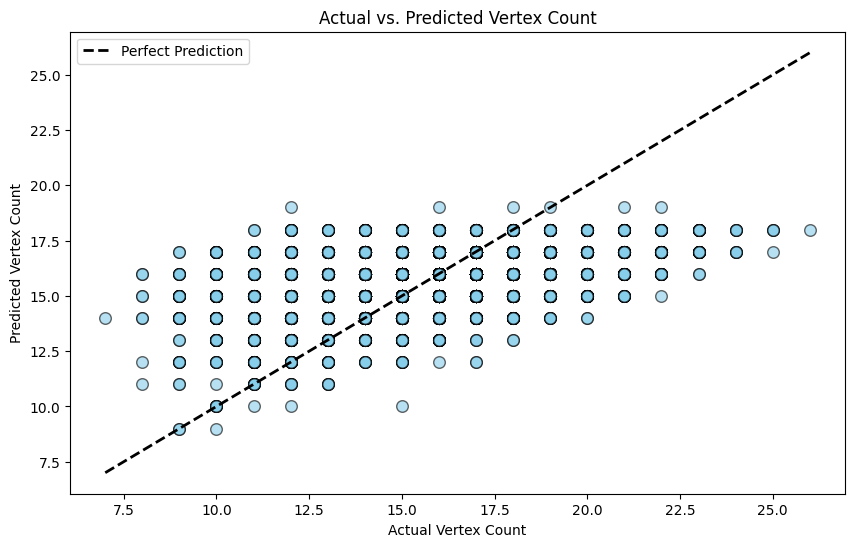

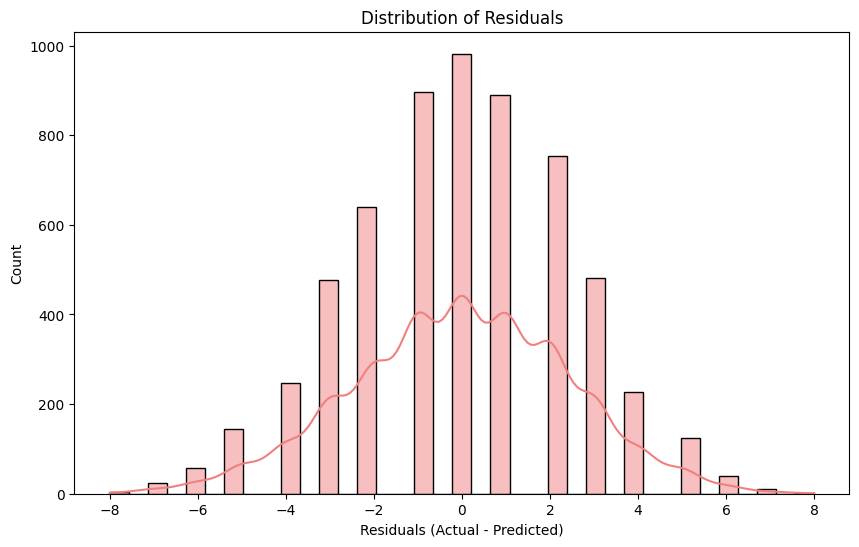

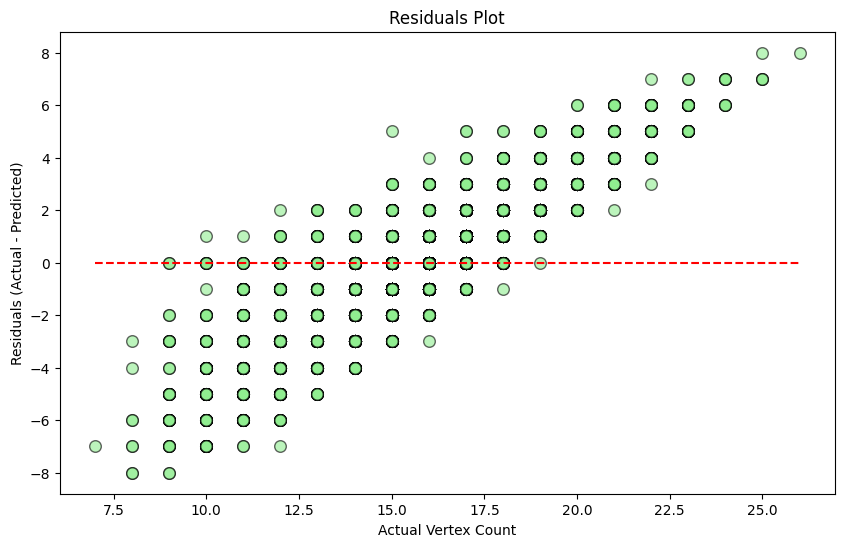

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="skyblue", edgecolor="black", s=70)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual Vertex Count")
plt.ylabel("Predicted Vertex Count")
plt.title("Actual vs. Predicted Vertex Count")
plt.legend()
plt.show()

# Residual plot (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="lightcoral", edgecolor="black")
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.show()

# Scatter plot of residuals to see patterns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6, color="lightgreen", edgecolor="black", s=70)
plt.hlines(0, y_test.min(), y_test.max(), colors="red", linestyles="dashed")
plt.xlabel("Actual Vertex Count")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot")
plt.show()

    vertex_count_actual  mean_absolute_error  median_absolute_error
9                    16             0.895858                    1.0
8                    15             1.041916                    1.0
10                   17             1.090216                    1.0
7                    14             1.485714                    1.0
11                   18             1.783276                    2.0
6                    13             2.207940                    2.0
12                   19             2.516355                    2.0
5                    12             2.979328                    3.0
13                   20             3.303887                    3.0
4                    11             3.511111                    4.0


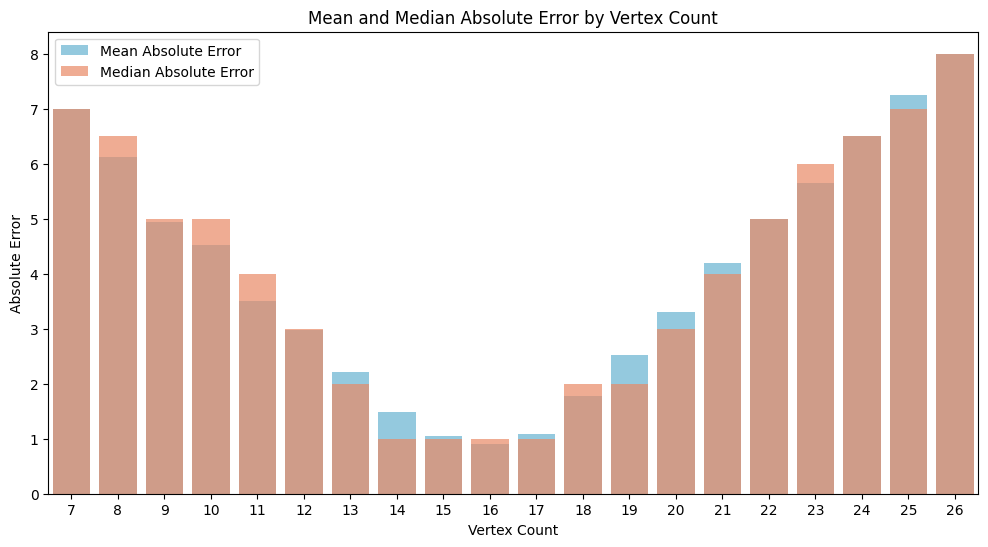

In [28]:
# Calculate absolute errors
errors = np.abs(y_test.values - y_pred)

# Create a DataFrame with actual, predicted, and errors
results_df = pd.DataFrame({
    "vertex_count_actual": y_test.values,
    "vertex_count_predicted": y_pred,
    "absolute_error": errors
})

# Group by actual vertex count and calculate mean and median absolute error
error_summary = results_df.groupby("vertex_count_actual")["absolute_error"].agg(["mean", "median"]).reset_index()
error_summary = error_summary.rename(columns={"mean": "mean_absolute_error", "median": "median_absolute_error"})

# Sort by mean absolute error to see which counts are best predicted
error_summary_sorted = error_summary.sort_values(by="mean_absolute_error")
print(error_summary_sorted.head(10))  # Display top 10 vertex counts with lowest mean error

# Plot the mean and median absolute errors
plt.figure(figsize=(12, 6))
sns.barplot(data=error_summary_sorted, x="vertex_count_actual", y="mean_absolute_error", color="skyblue", label="Mean Absolute Error")
sns.barplot(data=error_summary_sorted, x="vertex_count_actual", y="median_absolute_error", color="coral", alpha=0.7, label="Median Absolute Error")
plt.xlabel("Vertex Count")
plt.ylabel("Absolute Error")
plt.title("Mean and Median Absolute Error by Vertex Count")
plt.legend()
plt.show()